<ipython-input-1-0bdfb3630a4c>:126: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = color.rgb2gray(image)
<ipython-input-1-0bdfb3630a4c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])


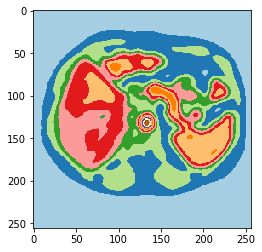

In [1]:
import numpy as np
from collections import deque

# Implementation of:
# Pierre Soille, Luc M. Vincent, "Determining watersheds in digital pictures via
# flooding simulations", Proc. SPIE 1360, Visual Communications and Image Processing
# '90: Fifth in a Series, (1 September 1990); doi: 10.1117/12.24211;
# http://dx.doi.org/10.1117/12.24211
class Watershed(object):
   MASK = -2
   WSHD = 0
   INIT = -1
   INQE = -3

   def __init__(self, levels = 256):
      self.levels = levels

   # Neighbour (coordinates of) pixels, including the given pixel.
   def _get_neighbors(self, height, width, pixel):
      return np.mgrid[
         max(0, pixel[0] - 1):min(height, pixel[0] + 2),
         max(0, pixel[1] - 1):min(width, pixel[1] + 2)
      ].reshape(2, -1).T

   def apply(self, image):
      current_label = 0
      flag = False
      fifo = deque()

      height, width = image.shape
      total = height * width
      labels = np.full((height, width), self.INIT, np.int32)

      reshaped_image = image.reshape(total)
      # [y, x] pairs of pixel coordinates of the flattened image.
      pixels = np.mgrid[0:height, 0:width].reshape(2, -1).T
      # Coordinates of neighbour pixels for each pixel.
      neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])
      if len(neighbours.shape) == 3:
         # Case where all pixels have the same number of neighbours.
         neighbours = neighbours.reshape(height, width, -1, 2)
      else:
         # Case where pixels may have a different number of pixels.
         neighbours = neighbours.reshape(height, width)

      indices = np.argsort(reshaped_image)
      sorted_image = reshaped_image[indices]
      sorted_pixels = pixels[indices]

      # self.levels evenly spaced steps from minimum to maximum.
      levels = np.linspace(sorted_image[0], sorted_image[-1], self.levels)
      level_indices = []
      current_level = 0

      # Get the indices that deleimit pixels with different values.
      for i in range(total):
         if sorted_image[i] > levels[current_level]:
            # Skip levels until the next highest one is reached.
            while sorted_image[i] > levels[current_level]: current_level += 1
            level_indices.append(i)
      level_indices.append(total)

      start_index = 0
      for stop_index in level_indices:
         # Mask all pixels at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            labels[p[0], p[1]] = self.MASK
            # Initialize queue with neighbours of existing basins at the current level.
            for q in neighbours[p[0], p[1]]:
               # p == q is ignored here because labels[p] < WSHD
               if labels[q[0], q[1]] >= self.WSHD:
                  labels[p[0], p[1]] = self.INQE
                  fifo.append(p)
                  break

         # Extend basins.
         while fifo:
            p = fifo.popleft()
            # Label p by inspecting neighbours.
            for q in neighbours[p[0], p[1]]:
               # Don't set lab_p in the outer loop because it may change.
               lab_p = labels[p[0], p[1]]
               lab_q = labels[q[0], q[1]]
               if lab_q > 0:
                  if lab_p == self.INQE or (lab_p == self.WSHD and flag):
                     labels[p[0], p[1]] = lab_q
                  elif lab_p > 0 and lab_p != lab_q:
                     labels[p[0], p[1]] = self.WSHD
                     flag = False
               elif lab_q == self.WSHD:
                  if lab_p == self.INQE:
                     labels[p[0], p[1]] = self.WSHD
                     flag = True
               elif lab_q == self.MASK:
                  labels[q[0], q[1]] = self.INQE
                  fifo.append(q)

         # Detect and process new minima at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            # p is inside a new minimum. Create a new label.
            if labels[p[0], p[1]] == self.MASK:
               current_label += 1
               fifo.append(p)
               labels[p[0], p[1]] = current_label
               while fifo:
                  q = fifo.popleft()
                  for r in neighbours[q[0], q[1]]:
                     if labels[r[0], r[1]] == self.MASK:
                        fifo.append(r)
                        labels[r[0], r[1]] = current_label

         start_index = stop_index

      return labels

if __name__ == "__main__":
   import sys
   from PIL import Image
   import matplotlib.pyplot as plt
   from skimage import color, io
   import scipy.ndimage
   import scipy.signal

   w = Watershed()
   image = io.imread('D:\studies\word_image_generator-master\Liver_MRI0001\phase1\img0059.dcm')
   image = color.rgb2gray(image)
   img_smooth = scipy.ndimage.filters.gaussian_filter(image, 4)
   labels = w.apply(img_smooth)
##   plt.imshow(labels, cmap='Paired', interpolation='nearest')
##   plt.show()
   plt.imshow(img_smooth, cmap='Paired', interpolation='nearest')
   plt.show()
   
